In [1]:
library(ArchR)
library(org.Ss.eg.db)
library(SuscrofaTxdb.11.108.july)
library(patchwork)
library(dplyr)
library(tidyr)
library(RColorBrewer)
library(scales)
library(cowplot)
library(ggrepel)


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   _ 

In [2]:
options(repr.plot.width = 18, repr.plot.height = 17, repr.plot.pointsize = 24)

In [3]:
addArchRThreads(1)
addArchRLocking(locking = TRUE)

Setting default number of Parallel threads to 1.

Setting ArchRLocking to TRUE.



In [4]:
custom_colors <- list()

colors_dutch <- c(
  '#FFC312','#C4E538','#12CBC4','#FDA7DF','#ED4C67',
  '#F79F1F','#A3CB38','#1289A7','#D980FA','#B53471',
  '#EE5A24','#009432','#0652DD','#9980FA','#833471',
  '#EA2027','#006266','#1B1464','#5758BB','#6F1E51'
)

colors_spanish <- c(
  '#40407a','#706fd3','#f7f1e3','#34ace0','#33d9b2',
  '#2c2c54','#474787','#aaa69d','#227093','#218c74',
  '#ff5252','#ff793f','#d1ccc0','#ffb142','#ffda79',
  '#b33939','#cd6133','#84817a','#cc8e35','#ccae62'
)

custom_colors$discrete <- c(colors_dutch, colors_spanish)

custom_colors$cell_cycle <- setNames(
  c('#45aaf2', '#f1c40f', '#e74c3c', '#7f8c8d'),
  c('G1',      'S',       'G2M',     '-')
)

In [5]:
load(file = "/home/adufour/work/rds_storage/omics/archr_all_v6_stemcells.RData")

In [6]:
archrproj_sub <- addCellColData(
  ArchRProj = archrproj_sub,
  data = gsub("J7", "EMB", gsub("J9", "EMB", gsub("J11", "EMB", gsub("lw7", "LNG", gsub("lw9", "LNG", getCellColData(archrproj_sub)$Time))))),
  name = "Origin",
  cells = getCellNames(archrproj_sub),
  force = FALSE
)

In [7]:
markerTest <- getMarkerFeatures(
  ArchRProj = archrproj_sub,
  useMatrix = "PeakMatrix",
  groupBy = "Origin",
  testMethod = "wilcoxon",
  bias = c("TSSEnrichment", "log10(nFrags)"),
  useGroups = "EMB",
  bgdGroups = "LNG"
)

ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-1578c7630d3ffe-Date-2024-03-07_Time-15-01-44.log
If there is an issue, please report to github with logFile!

MatrixClass = Sparse.Integer.Matrix

2024-03-07 15:01:45 : Matching Known Biases, 0.011 mins elapsed.

Warning message:
“le package ‘nabor’ a été compilé avec la version R 4.2.3”
2024-03-07 15:01:55 : Computing Pairwise Tests (1 of 1), 0.177 mins elapsed.

Pairwise Test EMB : Seqnames 1

Pairwise Test EMB : Seqnames 10

Pairwise Test EMB : Seqnames 11

Pairwise Test EMB : Seqnames 12

Pairwise Test EMB : Seqnames 13

Pairwise Test EMB : Seqnames 14

Pairwise Test EMB : Seqnames 15

Pairwise Test EMB : Seqnames 16

Pairwise Test EMB : Seqnames 17

Pairwise Test EMB : Seqnames 18

Pairwise Test EMB : Seqnames 2

Pairwise Test EMB : Seqnames 3

Pairwise Test EMB : Seqnames 4

Pairwise Test EMB : Seqnames 5

Pairwise Test EMB : Seqnames 6

Pairwise Test EMB : Seqnames 7

Pairwise Test EMB : Seqnames 8

Pairwise Test EMB : Seqname

In [9]:
barplot_df <- data.frame(class = c("AEpiblast", "CpESC", "BCommon"), value = c(1322, 15760, (189077-1322-15760)))

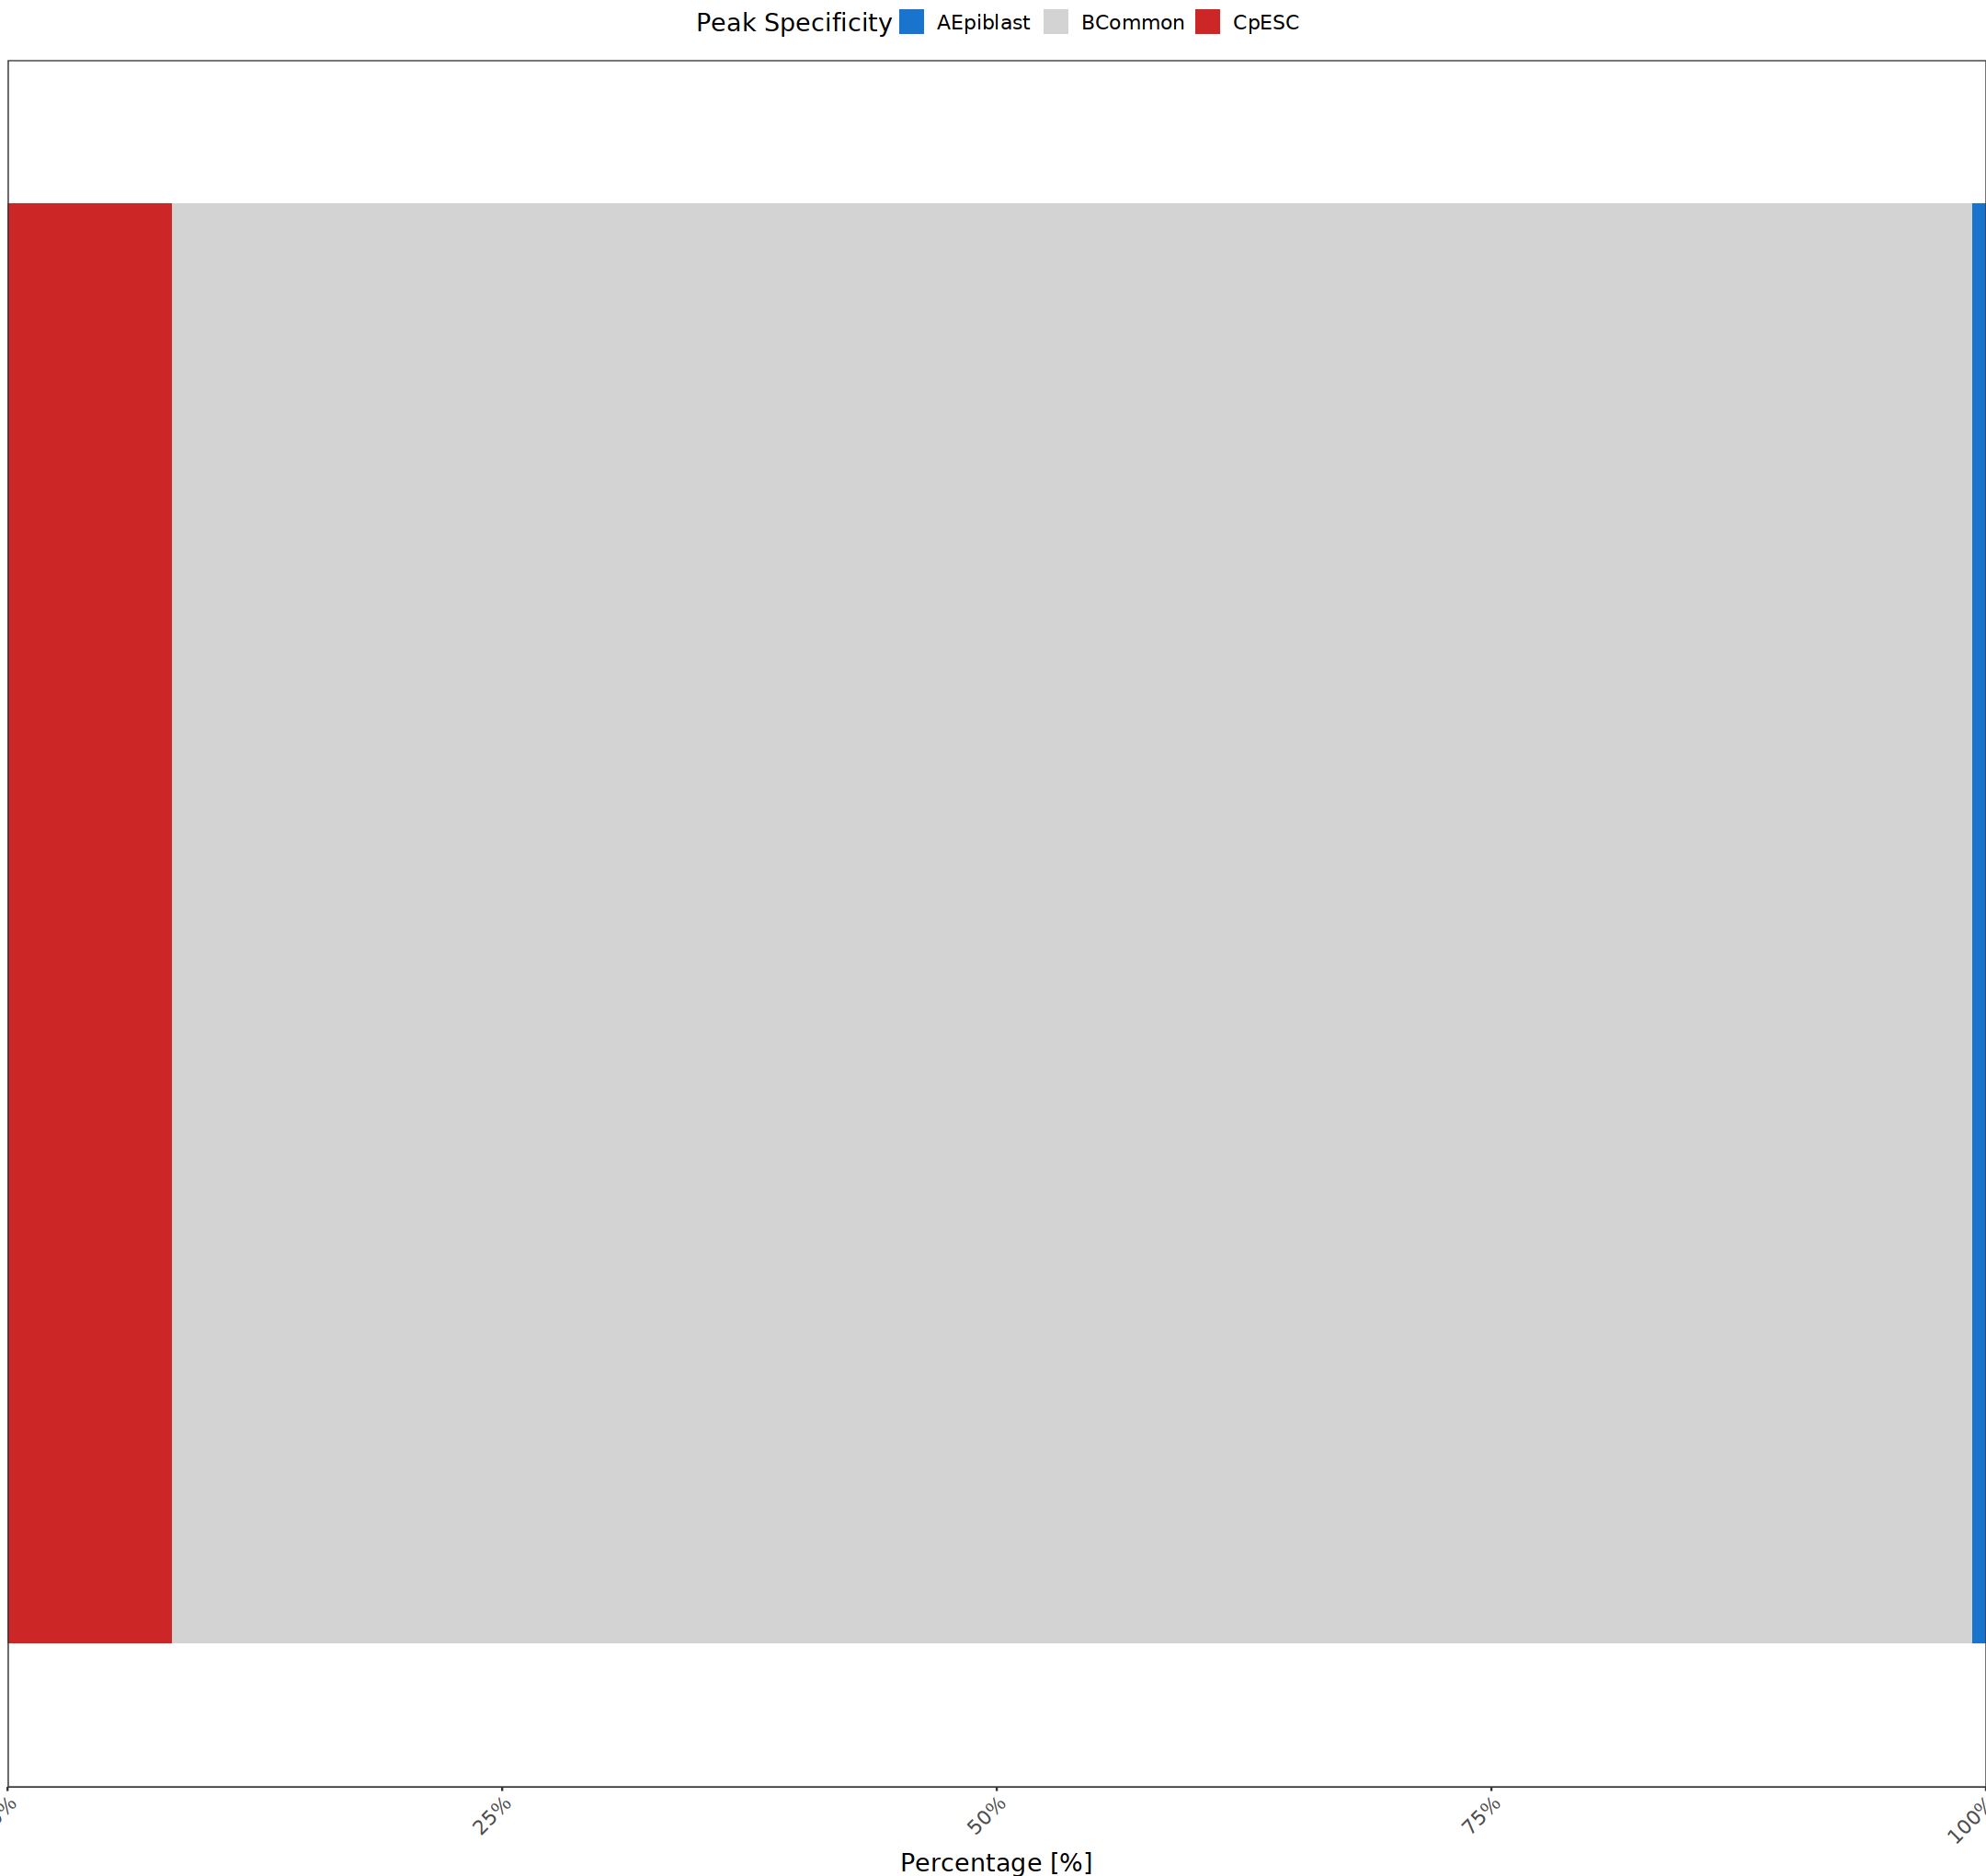

In [10]:
ggplot(barplot_df, aes("", value)) +
    geom_bar(aes(fill = class), position = 'fill', stat = 'identity', width = 1) +
    scale_fill_manual(name = 'Peak Specificity', values = c("#1874cd", "#d3d3d3", "#cd2626"), expand = c(0, 0)) +
    scale_y_continuous(name = 'Percentage [%]', labels = scales::percent_format(), expand = c(0, 0)) +
    coord_flip() +
    theme_bw() +
    theme(
        legend.position = 'top',
        text = element_text(size = 16),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.title.y = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1),
        axis.ticks.y = element_blank(),
        plot.margin = margin(t = 0, r = 0, b = 0, l = 0, unit = 'pt')
    )

In [9]:
p2geneDF <- metadata(archrproj_sub@peakSet)$Peak2GeneLinks
p2geneDF$geneName <- mcols(metadata(p2geneDF)$geneSet)$name[p2geneDF$idxRNA]
p2geneDF$peakName <- (metadata(p2geneDF)$peakSet %>% {paste0(seqnames(.), "_", start(.), "_", end(.))})[p2geneDF$idxATAC]
colnames(p2geneDF) <- c('idxATAC', 'idxRNA', 'Correlation', 'FDR_P2G', 'VarQATAC', 'VarQRNA', 'geneName', 'peakName')

In [22]:
plotMarkers <- function(
    seMarker = NULL,
    name = NULL,
    cutOff = "FDR <= 0.01 & abs(Log2FC) >= 0.5",
    plotAs = "Volcano",
    scaleTo = 10^4,
    P2Gdf = NULL
    ){

    #Evaluate AssayNames
    assayNames <- names(SummarizedExperiment::assays(seMarker))
    for(an in assayNames){
        eval(parse(text=paste0(an, " <- ", "SummarizedExperiment::assays(seMarker)[['", an, "']]")))
    }
    passMat <- eval(parse(text=cutOff))
    for(an in assayNames){
        eval(parse(text=paste0("rm(",an,")")))
    }
    passMat[is.na(passMat)] <- FALSE

    if(is.null(name)){
        name <- colnames(seMarker)[1]
    }
    
    if(!is.null(P2Gdf)){
        markerPeaks_name <- rowData(seMarker[,name])
        markerPeaks_name$peakName <- paste0(markerPeaks_name$seqnames, "_", markerPeaks_name$start, "_", markerPeaks_name$end)
        row_order <- markerPeaks_name$peakName
        markerPeaks_gene <- merge(markerPeaks_name,p2geneDF,by="peakName", all.x=TRUE)
        markerPeaks_gene <- markerPeaks_gene[order(markerPeaks_gene[,'peakName'],-markerPeaks_gene[,'Correlation']),]
        markerPeaks_gene <- markerPeaks_gene[!duplicated(markerPeaks_gene$peakName),]
        markerPeaks_gene <- markerPeaks_gene[match(row_order, markerPeaks_gene$peakName), ]
    }
  
    FDR <- assays(seMarker[,name])$FDR
    FDR <- as.vector(as.matrix(FDR))
    FDR[is.na(FDR)] <- 1

    LFC <- assays(seMarker[,name])$Log2FC
    LFC <- as.vector(as.matrix(LFC))
    qLFC <- max(quantile(abs(LFC), na.rm=TRUE), 4) * 1.05
    color <- ifelse(passMat[, name], "Differential", "Not-Differential")
    color[color == "Differential"] <- ifelse(LFC[color == "Differential"] > 0, "Epiblast-Specific", "pESC-Specific")

    pal <- c("Epiblast-Specific" = "firebrick3", "Not-Differential" = "lightgrey", "pESC-Specific" = "dodgerblue3")

    idx <- c(which(!passMat[, name]), which(passMat[, name]))

    emb_sep <- sum(color=="Epiblast-Specific")
    lng_sep <- sum(color=="pESC-Specific")
    com_sep <- nrow(seMarker) - emb_sep - lng_sep
    
    title <- sprintf("Number of features = %s\nNumber Epiblast-Regulated = %s (%s Percent)\nNumber pESC-Specific = %s (%s Percent)",
                    nrow(seMarker), emb_sep, 
                    round(100 * sum(color=="Epiblast-Specific") / nrow(seMarker), 2),
                    lng_sep, 
                    round(100 * sum(color=="pESC-Specific") / nrow(seMarker), 2)
    )
    x <- LFC[idx]
    y <- -log10(FDR[idx])
    label <- markerPeaks_gene[idx,"geneName"]
    size <- markerPeaks_gene[idx,"Correlation"]
    size <- size + 1
    size[ is.na(size) ] <- 1
    df <- data.frame(x = x, y = y, label = label, size = size)
    include <- which(is.finite(x) & is.finite(y))

    if(length(include) != length(x)){
        message("Some values are not finite! Excluding these points!")
        df <- df[include,]
        x <- x[include]
        y <- y[include]
        if(!is.null(color)){
          color <- color[include]
        }
    }
    xlim <- c(-qLFC, qLFC)
    ylim <- range(df$y) %>% extendrange(f = 0)
    ratioXY <- 1 * diff(xlim)/diff(ylim)
    color <- color[idx]
    colorTitle <- "color"
    stopifnot(length(color) == nrow(df))
    idx2 <- seq_along(x)
    barplot_df <- data.frame(class = c("AEpiblast", "CpESC", "BCommon"), value = c(emb_sep, lng_sep, com_sep))
    barplot <- ggplot(barplot_df, aes("", value)) +
            geom_bar(aes(fill = class), position = 'fill', stat = 'identity', width = 0.75) +
            scale_fill_manual(name = 'Peak Specificity', values = c("#cd2626", "#d3d3d3", "#1874cd"), expand = c(0, 0)) +
            scale_y_continuous(name = 'Percentage [%]', labels = scales::percent_format(), expand = c(0, 0)) +
            ggtitle(title) +
            coord_flip() +
            theme_bw() +
            theme(
                legend.position = 'top',
                text = element_text(size = 16),
                panel.grid.major = element_blank(),
                panel.grid.minor = element_blank(),
                axis.title.y = element_blank(),
                axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1),
                axis.ticks.y = element_blank(),
                plot.margin = margin(t = 0, r = 0, b = 0, l = 0, unit = 'pt')
            )
    volcanoplot <- ggplot(df[idx2,], aes(x = x, y = y, color = color, label = label)) +  
            coord_equal(ratio = ratioXY, xlim = xlim, ylim = ylim, expand = FALSE) + 
            xlab("Log2 Fold Change") +
            ylab("-Log10 FDR") + 
            theme_ArchR(baseSize = 10) +
            #geom_point(alpha = 1) +
            stat_bin2d(alpha = 1, bins = 500) +
            geom_text_repel(aes(label=ifelse(y>5,as.character(label),'')), size = 5, hjust=0, vjust=0) +
            scale_color_manual(values = pal) +
            geom_vline(xintercept = 0, lty = "dashed") +
            labs(color = colorTitle, size = "size") +
            theme_bw() +
            theme(legend.position = "right",
                  legend.key = element_rect(size = 2), 
                  legend.box.background = element_rect(color = NA),
                  axis.text.x = element_text(size = 20),
                  legend.text = element_text(size = 20),
                  legend.title = element_text(size = 20),
                  axis.title.y = element_text(size = 20),
                  axis.title.x = element_text(size = 20),
                  title = element_text(size = 20),
                  axis.text.y = element_text(size = 20)
            ) +
            scale_x_continuous(breaks = seq(-100, 100, 2), limits = c(-qLFC, qLFC), expand = c(0,0))

    graph_final <- ggdraw() +
    draw_plot(volcanoplot, 0, 0, 1, 0.75) +
    draw_plot(barplot, 0, .75, 1, .25)
}

In [10]:
p2geneDF <- p2geneDF[which(p2geneDF$Correlation > 0.5),]

Warning message:
“The following aesthetics were dropped during statistical transformation: label
ℹ This can happen when ggplot fails to infer the correct grouping structure in the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical variable into a factor?”
Warning message:
“Removed 57 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 121 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


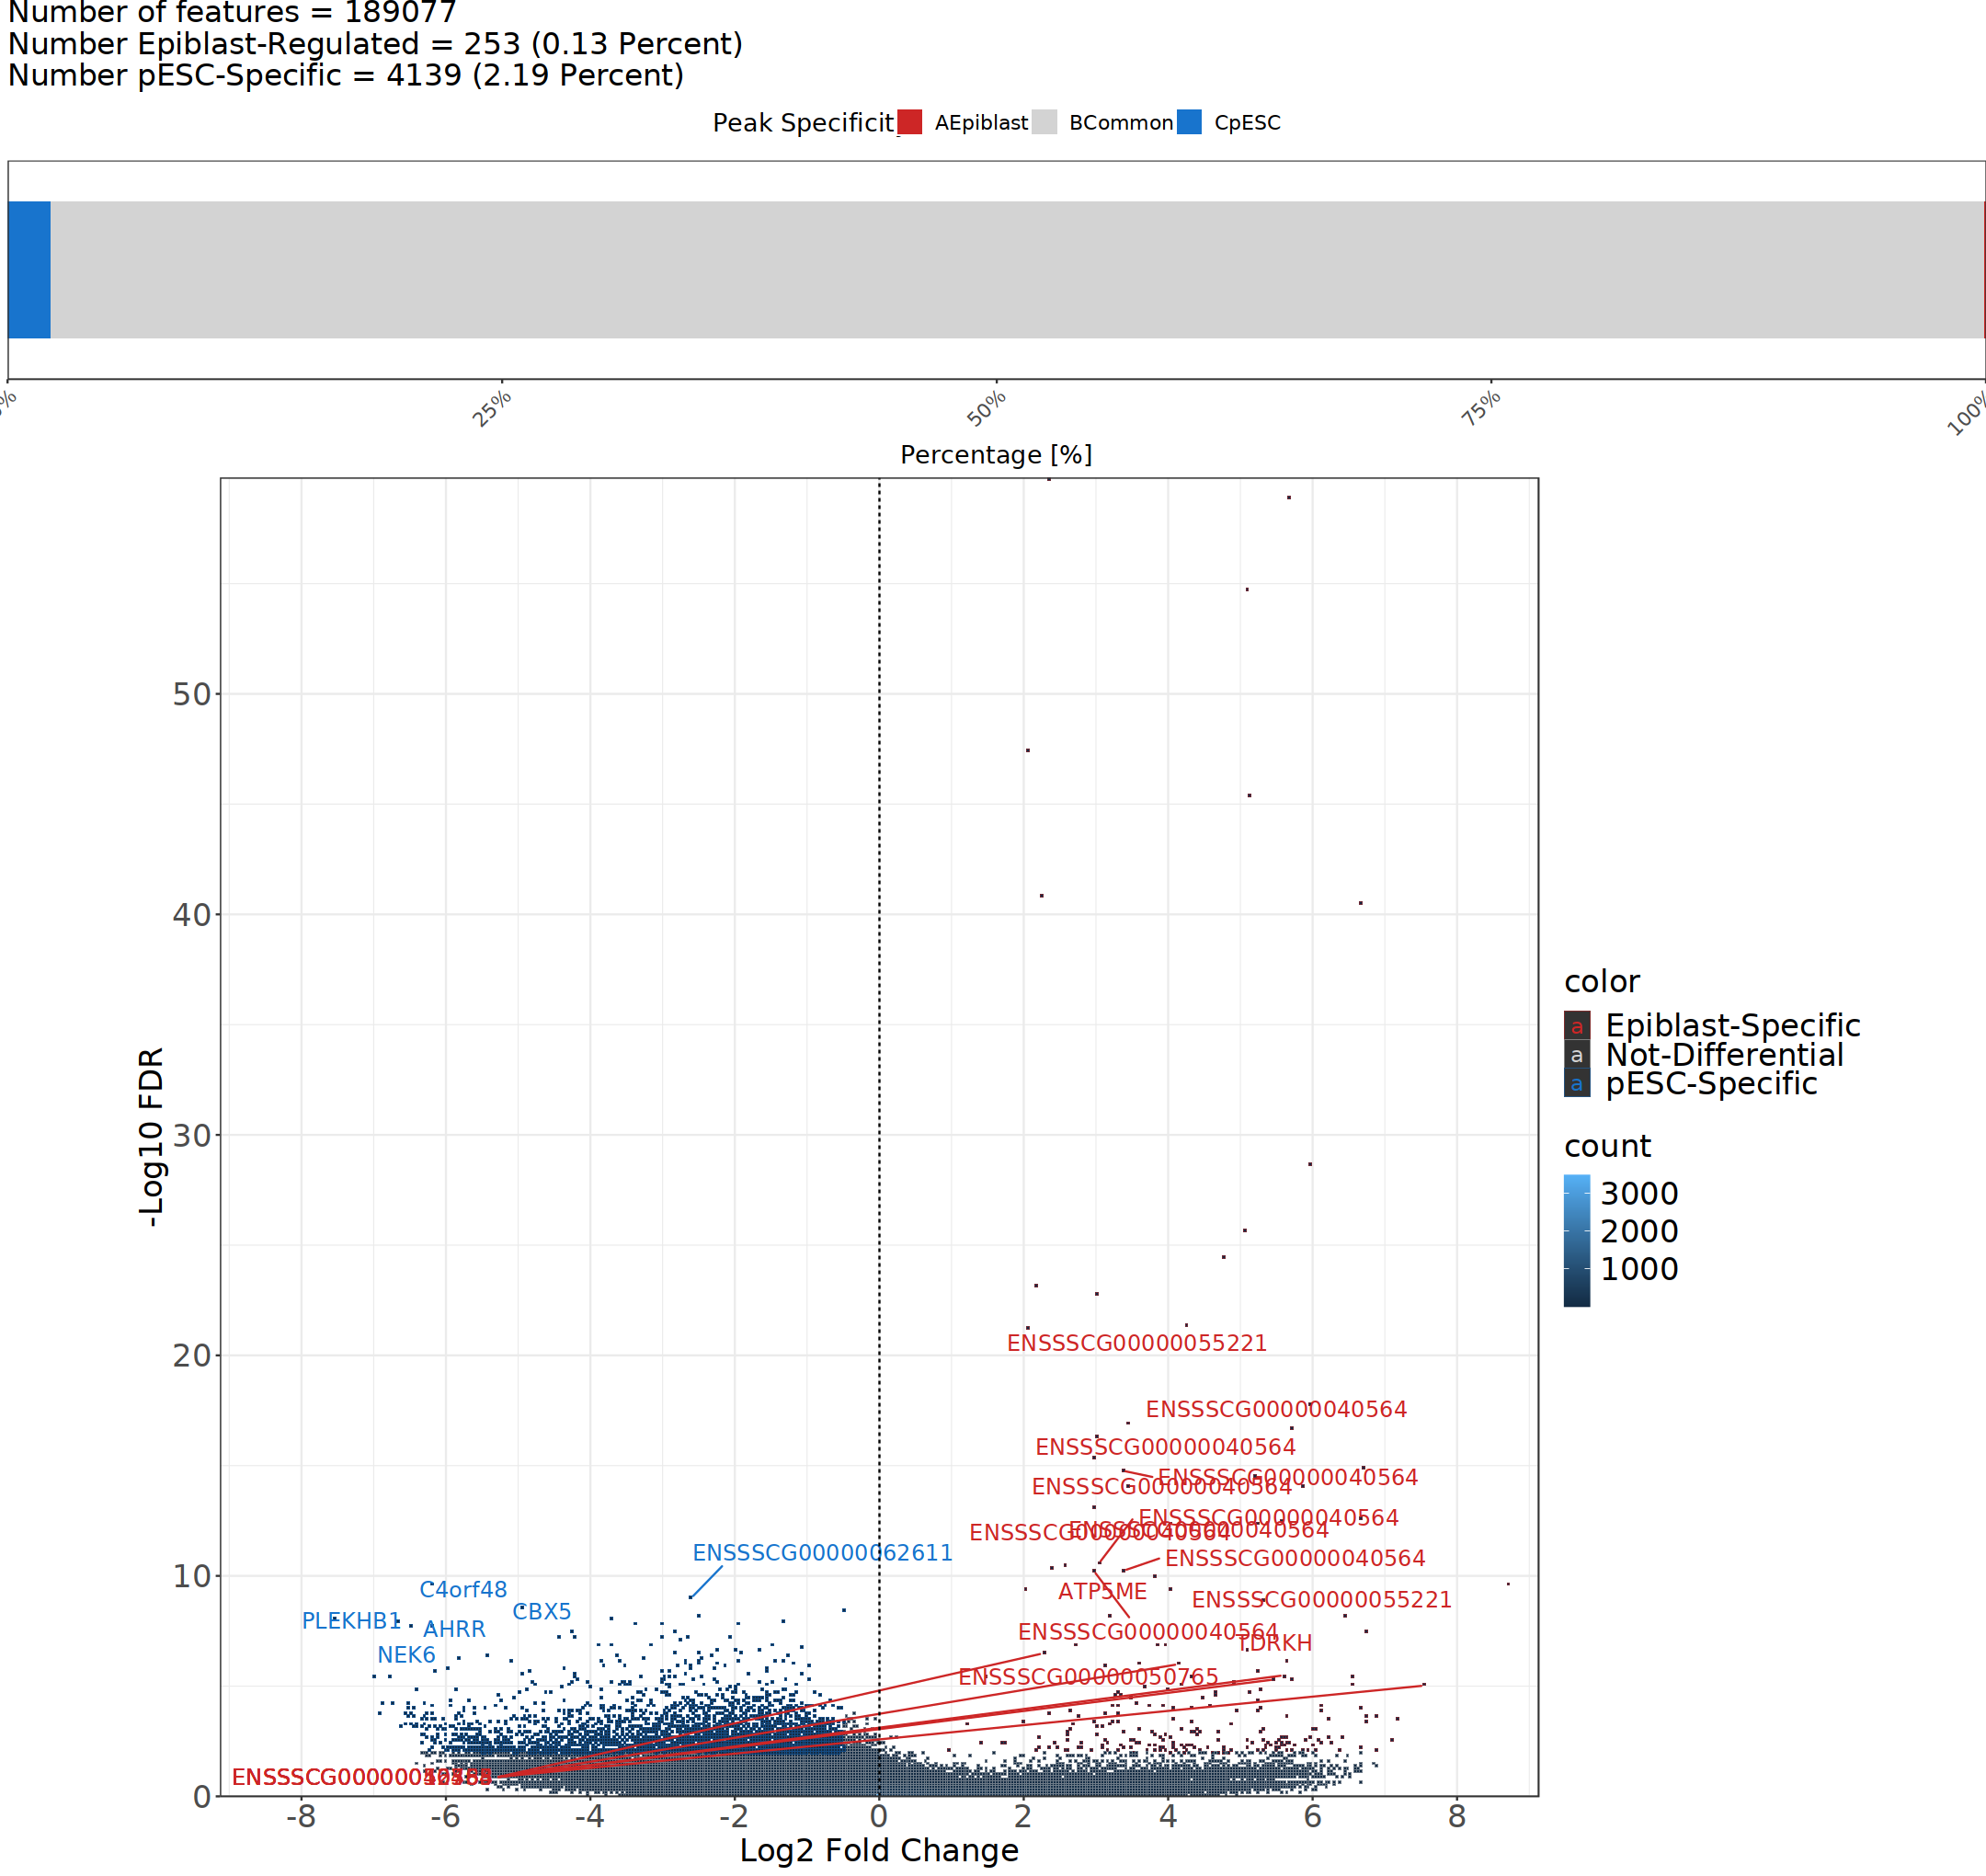

In [24]:
mat <- plotMarkers(
  seMarker = markerTest,
  name = "EMB",
  cutOff = "FDR <= 0.01 & abs(Log2FC) >= 0.5",
  plotAs = "Volcano",
  P2Gdf = p2geneDF,
  scaleTo = 10^4
)
mat

In [25]:
ggsave("/home/adufour/work/notebook/plots/omics/comp_emb_volcano.svg", mat, height = 26, width = 26)

Warning message:
“ggrepel: 82 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
